# LioNets: Turbofan Engine Degradation Simulation Dataset with Neural Networks

In this notebook, we present how LioNets can be applied in predictive models using time series data.

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
%matplotlib inline
from IPython.display import Image
from IPython.display import SVG
from IPython.display import display                               
from ipywidgets import interactive
from load_dataset import Load_Dataset
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd
import seaborn as sns
import numpy as np
import random
import re
from math import sqrt, exp, log
from sklearn.linear_model import Lasso, Ridge, RidgeCV, SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, balanced_accuracy_score, accuracy_score
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, TimeDistributed, RepeatVector,Flatten, Input, Dropout, LSTM, concatenate, Reshape, Conv1D, GlobalMaxPool1D
import keras.backend as K
from keras.utils import plot_model
from LioNets import LioNet

Using TensorFlow backend.


First of all, we load and clean our data.

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10425339150626863057
]


In [3]:
fm, feature_names = Load_Dataset.load_data_turbofan(False)

fm1_train = fm['FaultMode1']['df_train']
fm1_train_target = fm1_train['RUL'].values
fm1_test= fm['FaultMode1']['df_test']
fm1_test_target = fm1_test['RUL'].values

We are dropping some unecessary features.

In [4]:
LSTM_train = fm1_train.drop(columns=['t', 'os_1', 'os_2', 'os_3', 's_01', 's_05', 's_06', 's_10', 's_16', 's_18', 's_19', 's_22', 's_23', 's_24', 's_25', 's_26'])
LSTM_test = fm1_test.drop(columns=['t', 'os_1', 'os_2', 'os_3', 's_01', 's_05', 's_06', 's_10', 's_16', 's_18', 's_19', 's_22', 's_23', 's_24', 's_25', 's_26'])

We collect the different units, in order to the next steps to create time windows

In [5]:
train_units = set(LSTM_train['u'].values)
test_units = set(LSTM_test['u'].values)

We are scaling our data per feature

In [6]:
sensors = ['s_02', 's_03', 's_04', 's_07', 's_08', 's_09', 's_11', 's_12',
            's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
scalers = {}
for column in sensors:
    scaler = MinMaxScaler(feature_range=(0.1,1.1))
    LSTM_train[column] = scaler.fit_transform(LSTM_train[column].values.reshape(-1,1))
    LSTM_test[column] = scaler.transform(LSTM_test[column].values.reshape(-1,1))
    scalers[column] = scaler

We create time windows with a specific size. In this example, we create time windows of 50 timesteps.

In [7]:
unit_scalers = {}
window = 50
temp_LSTM_x_train = []
LSTM_y_train = []
for unit in train_units:
    temp_unit = LSTM_train[LSTM_train['u']==unit].drop(columns=['u','RUL']).values
    temp_unit_RUL = LSTM_train[LSTM_train['u']==unit]['RUL'].values
    
    for i in range(len(temp_unit) - window + 1):#elekse edw an len temp_unit - window > 0
        temp_instance = []
        for j in range(window):
            temp_instance.append(temp_unit[i+j])
        temp_LSTM_x_train.append(np.array(temp_instance))
        LSTM_y_train.append(temp_unit_RUL[i+window-1])
LSTM_y_train = np.array(LSTM_y_train)
LSTM_x_train = np.array(temp_LSTM_x_train)

temp_LSTM_x_test = []
LSTM_y_test = []
for unit in test_units:
    temp_unit = LSTM_test[LSTM_test['u']==unit].drop(columns=['u','RUL']).values
    temp_unit_RUL = LSTM_test[LSTM_test['u']==unit]['RUL'].values
        
    for i in range(len(temp_unit) - window + 1):#elekse edw an len temp_unit - window > 0
        temp_instance = []
        for j in range(window):
            temp_instance.append(temp_unit[i+j])
        temp_LSTM_x_test.append(np.array(temp_instance))
        LSTM_y_test.append(temp_unit_RUL[i+window-1])
LSTM_y_test = np.array(LSTM_y_test)
LSTM_x_test = np.array(temp_LSTM_x_test)

We can check how many train, test instances we have. These are changing regarding the time window size.

In [8]:
LSTM_x_train.shape, LSTM_x_test.shape, LSTM_y_train.shape, LSTM_y_test.shape

((15731, 50, 14), (8255, 50, 14), (15731,), (8255,))

Moreover, we scale our target data, in order to train our models faster

In [9]:
temp_LSTM_y_train = [[i] for i in LSTM_y_train]
temp_LSTM_y_test = [[i] for i in LSTM_y_test]
target_scaler = MinMaxScaler()
target_scaler.fit(temp_LSTM_y_train)
temp_LSTM_y_train = target_scaler.transform(temp_LSTM_y_train)
temp_LSTM_y_test = target_scaler.transform(temp_LSTM_y_test)

We need a rmse loss function too!

In [10]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

Now, we can build our predictor

In [11]:
feature_names = fm1_train.columns
encoder_input = Input(shape=(LSTM_x_train[0].shape))

encoder_x = LSTM(units=80, return_sequences=True, activation='tanh')(encoder_input)
encoder_x = Dropout(0.5)(encoder_x)
encoder_x = LSTM(units=40, return_sequences=False, activation='tanh')(encoder_x)

encoder_y = Conv1D(filters=40,kernel_size=3,activation='tanh')(encoder_input)
encoder_y = GlobalMaxPool1D()(encoder_y)

encoded = concatenate([encoder_x,encoder_y])
encoded = Dropout(0.5)(encoded)
encoded = Dense(80, activation='tanh')(encoded)#Relu and selu
encoded = Dropout(0.5)(encoded)
encoded = Dense(40, activation='tanh')(encoded)#Relu and selu
predictions = Dense(1, activation='sigmoid')(encoded)#Relu and selu
predictor = Model(encoder_input,predictions)

predictor.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])
#print(predictor.summary())

checkpoint_name = 'TEDS_Predictor_RUL.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 2, save_best_only = True, mode ='auto')

Then, we train the predictor.

In [12]:
#predictor.fit(LSTM_x_train, temp_LSTM_y_train, epochs=250, batch_size=512, shuffle=True, validation_split=0.3, verbose=2, callbacks=[checkpoint])

We load our weights, and we measure the performance.

In [13]:
weights_file = 'TEDS_Predictor_RUL.hdf5' # choose the best checkpoint few features
predictor.load_weights(weights_file) # load it
predictor.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])

In [14]:
temp_pred = target_scaler.inverse_transform(predictor.predict(LSTM_x_train))
predictions = [i[0] for i in temp_pred]
print('Train:',mean_absolute_error(LSTM_y_train,predictions),mean_squared_error(LSTM_y_train,predictions),sqrt(mean_squared_error(LSTM_y_train,predictions)))
print(r2_score(LSTM_y_train,predictions))

Train: 13.686472375760749 456.94272182388676 21.37621860441848
0.861136439080712


In [15]:
temp_pred = target_scaler.inverse_transform(predictor.predict(LSTM_x_test))
predictions = [i[0] for i in temp_pred]
print('Test:',mean_absolute_error(LSTM_y_test,predictions),mean_squared_error(LSTM_y_test,predictions),sqrt(mean_squared_error(LSTM_y_test,predictions)))
print(r2_score(LSTM_y_test,predictions))

Test: 22.81737622261625 1048.122686165827 32.37472295118256
0.6154013922038681


Then, we have to extract the encoder from our predictor.

In [16]:
encoder = Model(input=predictor.input, output=[predictor.layers[-2].output])
encoder.trainable = False
encoder.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])
#encoder.summary()

Now we are ready to extract for all instances, their encoded representation

In [17]:
encoded_LSTM_x_train = encoder.predict(LSTM_x_train)
encoded_LSTM_x_test = encoder.predict(LSTM_x_test)

And by that, we build the decoder.

In [18]:
encoded_input = Input(shape=(encoded_LSTM_x_train[0].shape))
decoded = Dense(120, activation='tanh')(encoded_input)
decoded = Dropout(0.5)(decoded)

decoded_y = RepeatVector(54)(decoded)
decoded_y = Conv1D(filters=50,kernel_size=5,activation='tanh')(decoded_y)

decoded_x = RepeatVector(50)(decoded)
decoded_x = LSTM(units=80, return_sequences=True, activation='tanh')(decoded_x)
decoded_x = Dropout(0.5)(decoded_x)
decoded_x = LSTM(units=50, return_sequences=True, activation='tanh')(decoded_x)

decoded = concatenate([decoded_x,decoded_y])
decoded = Dense(50, activation='sigmoid')(decoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(14, activation='sigmoid')(decoded)

decoder = Model(encoded_input,decoded)

decoder.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])
#print(decoder.summary())

checkpoint_name = 'TEDS_Decoder_RUL.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 2, save_best_only = True, mode ='auto')

In [19]:
#decoder.fit(encoded_LSTM_x_train, LSTM_x_train, epochs=250, batch_size=512, shuffle=True, validation_split=0.22, verbose=2, callbacks=[checkpoint])

In [20]:
wights_file = 'TEDS_Decoder_RUL.hdf5' # choose the best checkpoint few features
decoder.load_weights(wights_file) # load it
decoder.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])

In [21]:
#rmse, mae, mse
decoder.evaluate(encoded_LSTM_x_train,LSTM_x_train)

15731/15731 [==============================] - 12s 749us/step


[0.06759391282035349, 0.051279862313339225, 0.004572289627073574]

In [22]:
decoder.evaluate(encoded_LSTM_x_test,LSTM_x_test)

8255/8255 [==============================] - 6s 723us/step


[0.06781013575847909, 0.05133825168013573, 0.004601210768169287]

## LioNets Experiments
Having everything setted up, we are now ready to try our methodology. We first initialize LioNets. LioNets requires a predictor (the regressor itself), an encoder (extracted from the predictor), a decoder, as well as some data (for best results the training data, in order to push the neighbourhood generation through known distribution for the network)

In [23]:
lionet = LioNet(predictor, decoder, encoder, LSTM_x_train, target_scaler)

We used the target scaler to see the results with the actual RUL numbers. Elsewhere, we can skip adding the scaler to LioNets, but the results will be in a scale of 0-1.

In [24]:
temp_instance = LSTM_x_train[112].copy()
model = Ridge(alpha=1,fit_intercept=True,random_state=0)
weights, real_prediction, local_prediction = lionet.explain_instance(temp_instance,500,model)
weights = weights * temp_instance.reshape(700)

In [25]:
"Real prediction: " + str(real_prediction)[:7] + ", Local prediction: " + str(local_prediction)[:7]

'Real prediction: 29.0628, Local prediction: 29.2628'

We would like to increase the RUL!

From LioNets we acquired the weights of each sensor's measurements. Then we extract some statistics

In [26]:
sensors_all = {}
count = 0
for j in range(50):
    count2 = 0
    for i in sensors:
        sensors_all.setdefault(i,[]).append([j, weights[count+count2], temp_instance[j][count2],
                                             weights[count+count2]*temp_instance[j][count2]])
        count2 = count2 + 1
    count = count + 14
sensors_std = []
sensors_mean = []
sensors_max = []
sensors_min = []
for i in sensors_all:
    naa = np.array(sensors_all[i])[:,3]
    sensors_std.append(naa.std())
    sensors_mean.append(naa.mean())
    sensors_max.append(naa.max())
    sensors_min.append(naa.min())
    #print(i, naa.mean(), naa.std(), naa.max(), naa.min())
statistics = pd.DataFrame({"Sensor": list(sensors), "Mean": list(sensors_mean), "STD": list(sensors_std), 
                           "Max": list(sensors_max), "Min": list(sensors_min), 
                           "Max-Min": np.array(sensors_max) + np.array(sensors_min)})

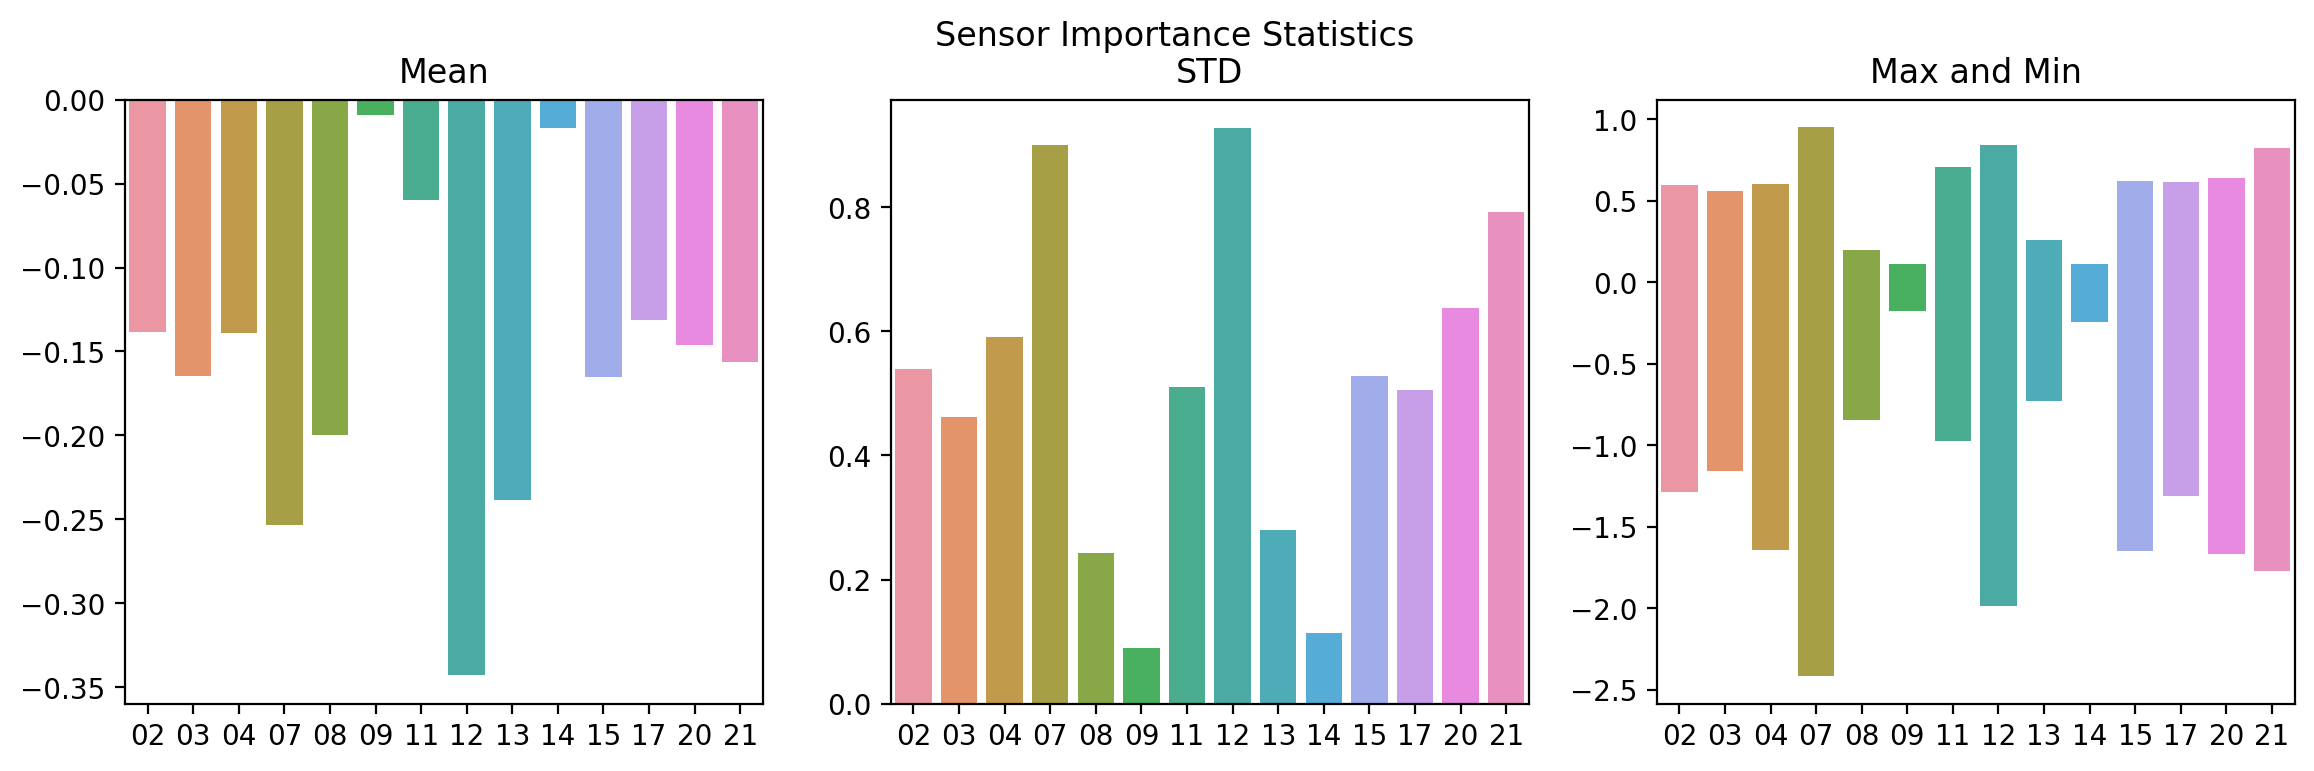

A Jupyter Widget

In [27]:
to_vis = [i[2:] for i in sensors]
fig, axs = plt.subplots(1, 3, figsize=(14, 4), dpi=200)
sns.barplot(to_vis,sensors_mean,ax=axs[0])
axs[0].set_title('Mean')
sns.barplot(to_vis,sensors_std,ax=axs[1])
axs[1].set_title('STD')
sns.barplot(to_vis,sensors_max,ax=axs[2])
sns.barplot(to_vis,sensors_min,ax=axs[2])
axs[2].set_title('Max and Min')
fig.suptitle('Sensor Importance Statistics')
plt.show()

def plot_sensor(sens_i=1):
    plt.figure(figsize=(14, 4), dpi=200, facecolor='w', edgecolor='k')
    plt.subplot(131)
    sns.lineplot(np.array(sensors_all['s_02'])[:,0],np.array(sensors_all[sensors[sens_i-1]])[:,1])
    plt.hlines(y=np.array(sensors_all[sensors[sens_i-1]])[:,1].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " influence"))
    plt.subplot(132)
    sns.lineplot(np.array(sensors_all['s_02'])[:,0],np.array(sensors_all[sensors[sens_i-1]])[:,2],color='g')
    plt.hlines(y=np.array(sensors_all[sensors[sens_i-1]])[:,2].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " value"))
    plt.subplot(133)
    sns.lineplot(np.array(sensors_all['s_02'])[:,0],np.array(sensors_all[sensors[sens_i-1]])[:,3],color='r')
    plt.hlines(y=np.array(sensors_all[sensors[sens_i-1]])[:,3].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " influence * value"))
    plt.show()
inter=interactive(plot_sensor 
   , sens_i=(1,14))
display(inter)

Let's modify the measurements from the s_12 sensor (number 8), which is is influencing negatively the RUL:

In [28]:
sens = 8-1
for i in range(50):
    if weights.reshape(50,14)[i:i+1,sens:sens+1][0] < 0:
        temp_instance[i:i+1,sens:sens+1][0]=temp_instance[i:i+1,sens:sens+1][0]-0.2
#sens = 5-1
#for i in range(50):
#    if weights.reshape(50,14)[i:i+1,sens:sens+1][0] < 0:
#        temp_instance[i:i+1,sens:sens+1][0]=temp_instance[i:i+1,sens:sens+1][0]-0.2

Now let's test the modified instance

In [29]:
model = Ridge(alpha=1,fit_intercept=True,random_state=0)
weights, real_prediction, local_prediction = lionet.explain_instance(temp_instance,500,model)
weights = weights * temp_instance.reshape(700)

In [30]:
"Real prediction: " + str(real_prediction)[:7] + ", Local prediction: " + str(local_prediction)[:7]

'Real prediction: 42.4361, Local prediction: 43.0921'

We managed to increase the RUL, a little. (Try and modify s_07 as well with the 12th sensor). How much does the RUL increased?

In [31]:
sensors_all = {}
count = 0
for j in range(50):
    count2 = 0
    for i in sensors:
        sensors_all.setdefault(i,[]).append([j, weights[count+count2], temp_instance[j][count2],
                                             weights[count+count2]*temp_instance[j][count2]])
        count2 = count2 + 1
    count = count + 14
sensors_std = []
sensors_mean = []
sensors_max = []
sensors_min = []
for i in sensors_all:
    naa = np.array(sensors_all[i])[:,3]
    sensors_std.append(naa.std())
    sensors_mean.append(naa.mean())
    sensors_max.append(naa.max())
    sensors_min.append(naa.min())
    #print(i, naa.mean(), naa.std(), naa.max(), naa.min())
statistics = pd.DataFrame({"Sensor": list(sensors), "Mean": list(sensors_mean), "STD": list(sensors_std), 
                           "Max": list(sensors_max), "Min": list(sensors_min), 
                           "Max-Min": np.array(sensors_max) + np.array(sensors_min)})

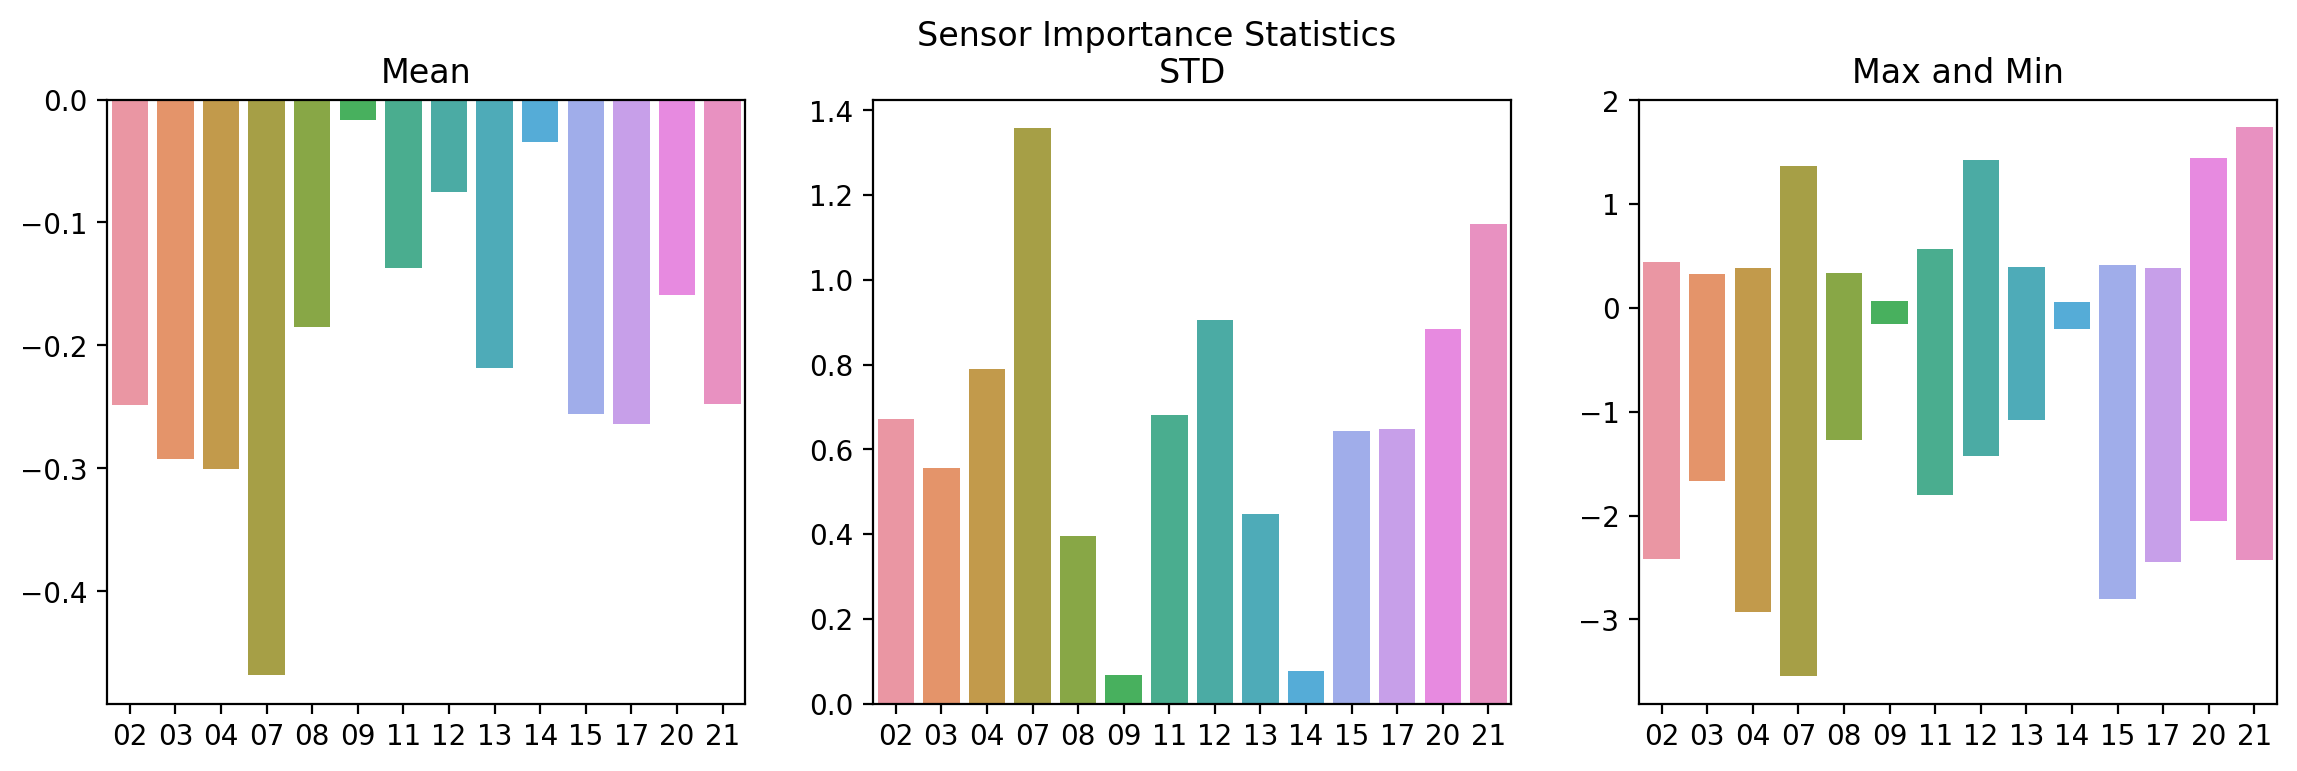

A Jupyter Widget

In [32]:
to_vis = [i[2:] for i in sensors]
fig, axs = plt.subplots(1, 3, figsize=(14, 4), dpi=200)
sns.barplot(to_vis,sensors_mean,ax=axs[0])
axs[0].set_title('Mean')
sns.barplot(to_vis,sensors_std,ax=axs[1])
axs[1].set_title('STD')
sns.barplot(to_vis,sensors_max,ax=axs[2])
sns.barplot(to_vis,sensors_min,ax=axs[2])
axs[2].set_title('Max and Min')
fig.suptitle('Sensor Importance Statistics')
plt.show()

def plot_sensor(sens_i=1):
    plt.figure(figsize=(14, 4), dpi=200, facecolor='w', edgecolor='k')
    plt.subplot(131)
    sns.lineplot(np.array(sensors_all['s_02'])[:,0],np.array(sensors_all[sensors[sens_i-1]])[:,1])
    plt.hlines(y=np.array(sensors_all[sensors[sens_i-1]])[:,1].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " influence"))
    plt.subplot(132)
    sns.lineplot(np.array(sensors_all['s_02'])[:,0],np.array(sensors_all[sensors[sens_i-1]])[:,2],color='g')
    plt.hlines(y=np.array(sensors_all[sensors[sens_i-1]])[:,2].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " value"))
    plt.subplot(133)
    sns.lineplot(np.array(sensors_all['s_02'])[:,0],np.array(sensors_all[sensors[sens_i-1]])[:,3],color='r')
    plt.hlines(y=np.array(sensors_all[sensors[sens_i-1]])[:,3].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " influence * value"))
    plt.show()
inter=interactive(plot_sensor 
   , sens_i=(1,14))
display(inter)

Try for another instance, and play with the plots :) Thanks for using LioNets.

For any question contact us at GitHub repo: https://github.com/intelligence-csd-auth-gr/LionLearn.git

or at our lab's website: https://intelligence.csd.auth.gr